In [11]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Lettura del file pickle
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [4]:
ball_positions = [x.get(1, []) for x in ball_positions] #Prende le posizioni della pallina da ogni frame e in caso di non rilevamento, restituisce una lista vuota

df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2']) #Crea un DataFrame con le posizioni della pallina
df_ball_positions = df_ball_positions.interpolate(method='linear') #Interpolazione lineare per riempire i valori mancanti
df_ball_positions = df_ball_positions.bfill() #Riempe un eventuale valore mancante all'inizio del dataframe con i valori successivi


Utilizzo la media mobile per smussare i valori rumorosi ed eliminare gli outliers:

In [7]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2 #Calcola la coordinata y del centro della pallina
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean() #Calcola la media mobile della coordinata y del centro della pallina



In [8]:
df_ball_positions

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean
0,893.032471,615.244629,912.244263,635.831543,625.538086,625.538086
1,893.032471,615.244629,912.244263,635.831543,625.538086,625.538086
2,878.989929,628.924942,897.946747,649.224838,639.074890,630.050354
3,864.947388,642.605255,883.649231,662.618134,652.611694,635.690689
4,850.904846,656.285568,869.351715,676.011429,666.148499,641.782251
...,...,...,...,...,...,...
209,1185.438477,248.956940,1199.633301,265.525024,257.240982,283.788275
210,1184.789062,233.821472,1195.593018,245.509918,239.665695,269.654300
211,1183.991211,227.414108,1196.107910,241.618607,234.516357,257.145188
212,1179.408203,213.949219,1194.058838,229.465805,221.707512,244.729035


Text(0.5, 0, 'Frames')

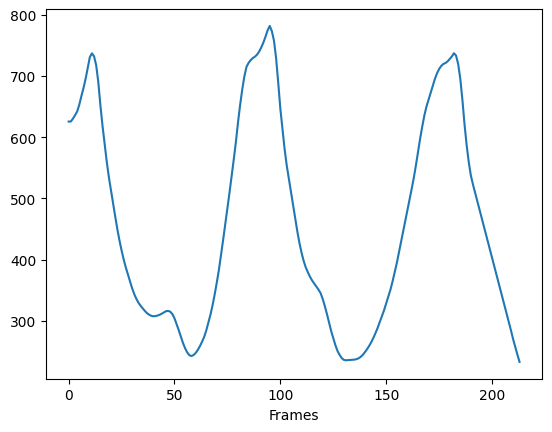

In [16]:
plt.plot(df_ball_positions['mid_y_rolling_mean'])

plt.xlabel('Frames')

Attraverso il grafico precedente è possibile vedere i frame in cui la pallina rimbalza a terra(rappresentato da un punto di massimo o minimo locale) e il frame in cui viene colpita dal giocatore(rappresentato dai picchi del grafico)

In [15]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff() #Calcola la differenza tra il valore attuale e quello precedente della media mobile della coordinata y del centro della pallina

Text(0.5, 0, 'Frames')

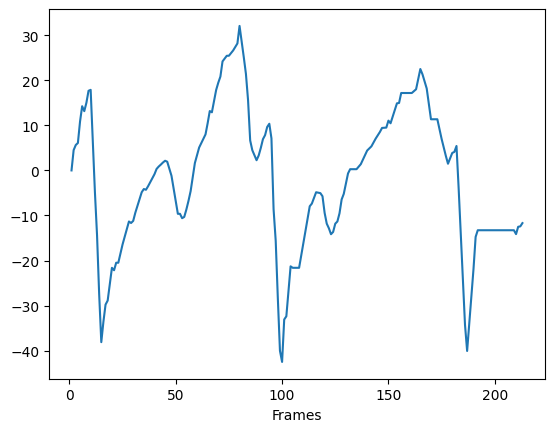

In [17]:
plt.plot(df_ball_positions['delta_y'])

plt.xlabel('Frames')

Analizzando il grafico sovraimpressione, si può notare come il frame in cui la pallina viene colpita è seguito da all'incirca 25 frame in cui il grafico continua a crescere (o a decrescere) con solo qualche piccolo rumore.

E' possibile sfruttare questa analisi per determinare i frame in cui la pallina viene colpita da un giocatore

In [18]:
#Inizializza la colonna 'ball_hit' a 0

df_ball_positions['ball_hit'] = 0


In [19]:
minimum_change_frames_for_hit = 25    #Per riconoscere il frame in cui la pallina viene colpita, nel grafico di delta_y, la funzione deve crescere o decrescere per almeno 25 frames consecutivi
for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit * 1.2)): #Controlla se la funzione decresce per almeno minimum_change_frames_for_hit frames nei successivi 1.2*minimum_change_frames_for_hit frames(è un cuscinetto per evitare falsi positivi dovuti a rumore)
    negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0

    if negative_position_change or positive_position_change:
        change_count = 0
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[change_frame] < 0 
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[change_frame] > 0

            if negative_position_change_following_frame and negative_position_change: #Se la funzione sta contiuando a decrescere...
                change_count += 1

            elif positive_position_change_following_frame and positive_position_change: #...o a crescere
                change_count += 1 #Incrementa il contatore
        
        if change_count >= minimum_change_frames_for_hit:
            df_ball_positions['ball_hit'].iloc[i] = 1


C:\Users\turch\AppData\Local\Temp\ipykernel_7068\4186373423.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1
C:\Users\turch\AppData\Local\Temp\ipykernel_7068\4186373423.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1
C:\Users\turch\AppData\Local\Temp\ipykernel_7068\4186373423.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_position

In [21]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,777.999756,717.641602,797.453979,739.491760,728.566681,736.933167,6.357050,1
58,926.004480,241.152512,938.492407,254.119803,247.636157,242.607499,-1.479028,1
95,615.796631,775.639160,637.650757,801.840088,788.739624,781.691895,7.109326,1
131,716.971283,229.938141,728.862366,242.580330,236.259235,235.711515,-0.670242,1
182,1294.892944,739.738220,1314.579346,759.444763,749.591492,737.134845,5.425134,1


Il numero di colpi indiviudato è 5 e 5 sono i colpi che avvengono nel video di prova

In [23]:
frames_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()
#Così facendo, si ottengono i frame in cui la pallina viene colpita

Le analisi effettuate in questo notebook sono state inserite nella classe BallTracker